# Convert a TensorFlow Model to OpenVINO™

This short tutorial shows how to convert a TensorFlow [MobileNetV3](https://docs.openvino.ai/latest/omz_models_model_mobilenet_v3_small_1_0_224_tf.html) image classification model to OpenVINO [Intermediate Representation](https://docs.openvino.ai/latest/openvino_docs_MO_DG_IR_and_opsets.html) (OpenVINO IR) format, using [Model Optimizer](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html). After creating the OpenVINO IR, load the model in [OpenVINO Runtime](https://docs.openvino.ai/latest/openvino_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html) and do inference with a sample image.  

## Imports

In [2]:
import time
from pathlib import Path
import PIL
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown
from openvino.runtime import Core
import tensorflow as tf


## Settings

In [3]:
# # The paths of the source and converted models.
# model_path = Path("model/saved_model.pb")
# ir_path = Path(model_path).with_suffix(".xml")

In [4]:
# The paths of the source and converted models.
model_path = Path("../../defectdetection\imt\path_to_my_model4_stepped")
ir_path = Path("../../defectdetection\imt\path_to_my_model4_stepped/saved_model.pb").with_suffix(".xml")
ir_model_name = "BS"

In [5]:
model_path, ir_path

(WindowsPath('../../defectdetection/imt/path_to_my_model4_stepped'),
 WindowsPath('../../defectdetection/imt/path_to_my_model4_stepped/saved_model.xml'))

## Convert a Model to OpenVINO IR Format

### Convert a TensorFlow Model to OpenVINO IR Format

Use Model Optimizer to convert a TensorFlow model to OpenVINO IR with `FP16` precision. The models are saved to the current directory. Add mean values to the model and scale the output with the standard deviation with `--scale_values`. With these options, it is not necessary to normalize input data before propagating it through the network. The original model expects input images in `RGB` format. The converted model also expects images in `RGB` format. If you want the converted model to work with `BGR` images, use the `--reverse-input-channels` option. For more information about Model Optimizer, including a description of the command-line options, see the [Model Optimizer Developer Guide](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html). For information about the model, including input shape, expected color order and mean values, refer to the [model documentation](https://docs.openvino.ai/latest/omz_models_model_mobilenet_v3_small_1_0_224_tf.html).

First construct the command for Model Optimizer, and then execute this command in the notebook by prepending the command with an `!`. There may be some errors or warnings in the output. When model optimization is successful, the last lines of the output will include `[ SUCCESS ] Generated IR version 11 model.`

for Tensorflow 1 --input_model "{model_path}"
for Tensorflow 2 --saved_model_dir <SAVED_MODEL_DIRECTORY>

In [6]:
# # Construct the command for Model Optimizer.
# mo_command = f"""mo
#                  --saved_model_dir "{model_path}" 
#                  --input 0,1
#                  --transformations_config "C:\\Program Files (x86)\\Intel\\oneAPI\\intelpython\\python3.9\\envs\\2022.2.0\\openvino_env\\Lib\\site-packages\\openvino\\tools\mo\\front\\tf\\automl_efficientdet.json"
#                  --input_shape "[1,150,150,3]" 
#                  --mean_values="[127.5,127.5,127.5]"
#                  --scale_values="[127.5]" 
#                  --data_type FP16 
#                  --output_dir "ir_model"
#                  --model_name "{ir_model_name}"
#                  """
# mo_command = " ".join(mo_command.split())
# print("Model Optimizer command to convert TensorFlow to OpenVINO:")
# display(Markdown(f"`{mo_command}`"))

In [7]:
# Construct the command for Model Optimizer.
mo_command = f"""mo
                 --saved_model_dir "{model_path}" 
                 --input_shape "[1,150,150,3]" 
                 --data_type "FP16"
                 --output_dir "ir_model"
                 --model_name "{ir_model_name}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert TensorFlow to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert TensorFlow to OpenVINO:


`mo --saved_model_dir "..\..\defectdetection\imt\path_to_my_model4_stepped" --input_shape "[1,150,150,3]" --data_type "FP16" --output_dir "ir_model" --model_name "BS"`

In [8]:
# Run Model Optimizer if the IR model file does not exist
if not ir_path.exists():
    print("Exporting TensorFlow model to IR... This may take a few minutes.")
    ! $mo_command
else:
    print(f"IR model {ir_path} already exists.")

Exporting TensorFlow model to IR... This may take a few minutes.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	d:\Edu\IntelOneAPI\myprojects\ir_model
	- IR output name: 	BS
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,150,150,3]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model conversion into IR: 	False
	- Force the usage 

## Test Inference on the Converted Model

### Load the Model

In [9]:
ie = Core()
model = ie.read_model(model="ir_model/BS.xml", weights="ir_model/BS.bin")
compiled_model = ie.compile_model(model=model, device_name="CPU")

### Get Model Information

In [10]:
input_key = compiled_model.input(0)
output_key = compiled_model.output(0)
network_input_shape = input_key.shape 
print(input_key)
print(output_key)
print(network_input_shape)

<ConstOutput: names[Func/StatefulPartitionedCall/input/_0:0, input_5, input_5:0] shape{1,150,150,3} type: f32>
<ConstOutput: names[Func/StatefulPartitionedCall/output/_1334:0, Identity:0, StatefulPartitionedCall/Identity:0, StatefulPartitionedCall/sequential_4/dense_9/Sigmoid:0] shape{1,1} type: f32>
{1, 150, 150, 3}


### Preprocessing Image Function

In [11]:
def pre_process_image(imagePath, img_height=150):
    # Model input format
    n, h, w, c = [1, img_height, img_height, 3]
    image = Image.open(imagePath)
    image = image.resize((h, w), resample=Image.BILINEAR)

    # Convert to array and change data layout from HWC to CHW
    image = np.array(image)
    input_image = image.reshape((n, h, w, c))

    return input_image

### Load an Image

Load an image, resize it, and convert it to the input shape of the network.

C:\Users\Arun G\AppData\Local\Temp\ipykernel_30164\2566977756.py:5: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize((h, w), resample=Image.BILINEAR)


(150, 150)


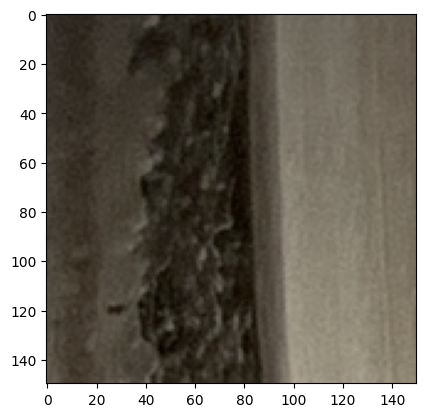

In [83]:
# # The MobileNet network expects images in RGB format.
# image = cv2.cvtColor(cv2.imread(filename="data/coco.jpg"), code=cv2.COLOR_BGR2RGB)
#file_path = "../../defectdetection/imt/split_files2/Test/Pitted/P (10412).png"
file_path = "../../defectdetection/imt/split_files2/Test/Pitted/P (10008).png"
#file_path = "../../defectdetection/imt/split_files2/Test/NotPitted/N (663)_.png"
# Resize the image to the network input shape.
image = Image.open(file_path)
#resized_image = cv2.resize(src=image, dsize=(150, 150))
resized_image = pre_process_image(file_path)
# # Transpose the image to the network input shape.
input_image = np.expand_dims(resized_image, 0)
print(image.size)
plt.imshow(image);

In [84]:
# # Resize the image to the network input shape.
#file_path = "../../defectdetection/imt/split_files2/Test/Pitted/P (10008).png"
# file_path = "../../defectdetection/imt/split_files2/Test/NotPitted/N (663)_.png"

# image = cv2.imread(filename=file_path)
# resized_image = cv2.resize(src=image, dsize=(150, 150))

# # Transpose the image to the network input shape.
# input_image = np.expand_dims(resized_image, 0)

# plt.imshow(image);

### Do Inference

In [85]:
print(resized_image.shape)
print(input_key.shape)

result = compiled_model([resized_image])[output_key]
result[0]


(1, 150, 150, 3)
{1, 150, 150, 3}


array([0.9999915], dtype=float32)

In [86]:
score = tf.nn.sigmoid(result[0])
print(score)
print(result[0])

tf.Tensor([0.7310569], shape=(1,), dtype=float32)
[0.9999915]


In [87]:
class_names = ['NotPitted', 'Pitted']
np.round(result[0])

array([1.], dtype=float32)

In [88]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[int(np.round(result[0]))], 100 * np.max(score))
)

This image most likely belongs to Pitted with a 73.11 percent confidence.


## Timing

Measure the time it takes to do inference on thousand images. This gives an indication of performance. For more accurate benchmarking, use the [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html) in OpenVINO. Note that many optimizations are possible to improve the performance. 

In [91]:
num_images = 1000

start = time.perf_counter()

for _ in range(num_images):
    compiled_model([resized_image])

end = time.perf_counter()
time_ir = end - start

print(
    f"IR model in OpenVINO Runtime/CPU: {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)

IR model in OpenVINO Runtime/CPU: 0.0562 seconds per image, FPS: 17.81
